# Introduction
we will undertake the analysis of the LFP signal derived from the brain of an anesthetized rat during an olfactory task. <br>
The LFP signal that is given to you comprises three distinct channels: <br>

&emsp;  1. Hippocampus (HPC) <br>
&emsp;  2. Olfactory Tubercle (OT) <br>
&emsp;  3. Medial Prefrontal Cortex (mPFC) <br>

Throughout the task, the anesthetized rat was exposed to two different odorants: <br>

&emsp;  1. Banana (tag = "20") <br>
&emsp;  2. Lime (tag = "40") <br>

Each odorant was presented with an equal probability of 50%. This implies that 50% of the time, the rat was exposed to the banana odor, and the remaining 50% to the lime odor. Upon cessation of odorant release, the resting state (tag = "10") commenced, devoid of any odor stimuli. <br>



# Import Libraries

In [ ]:
%pip install pymatreader

import numpy as np
import matplotlib.pyplot as plt
import pymatreader
import scipy as sp
import pandas as pd
import math
import scipy.io
#################################

# Reading the Data


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = scipy.io.loadmat('/content/drive/MyDrive/data.mat')

data['srate'] = 2000                            # Sampling rate
data['channel_names'] = ['HPC','OT','mPFC']     # The name of each channel
data['events'] = ['rest','banana','lime']       # Events names
data['tags'] = [10,20,40]                       # Tag of each event

###########################################################
channel_data={}
l=len(data['channelData'])
channel_data['HPC'],channel_data['OT'],channel_data['mPFC'] = data['channelData'][0:l,0],data['channelData'][0:l,1],data['channelData'][0:l,2]
channel_data['digitalbyte'] = data['channelData'][0:l,3]
channel_data['time']=np.array([i/2000 for i in range(l)])
###########################################################


# Plot the raw LFP


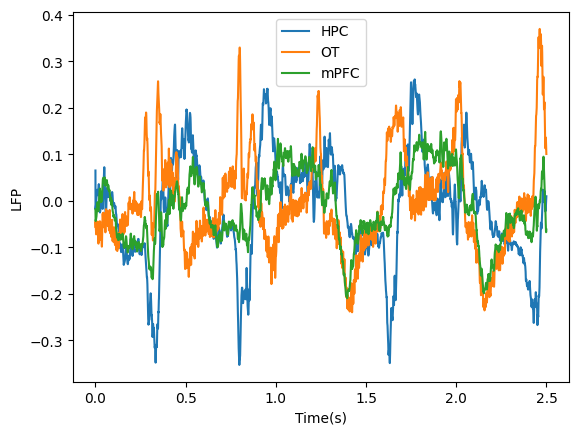

In [ ]:

#################################################
plt.plot(channel_data['time'][0:5000],channel_data['HPC'][0:5000]) #since the sampling rate is 2000, we can consider first 5000 values of given arrays
plt.plot(channel_data['time'][0:5000],channel_data['OT'][0:5000])
plt.plot(channel_data['time'][0:5000],channel_data['mPFC'][0:5000])
plt.legend(['HPC','OT','mPFC'])
plt.xlabel('Time(s)')
plt.ylabel('LFP')
plt.show()
#################################################


# Power Spectrum Density (PSD)


In [ ]:
def calc_PSD(data,sample_rate,high_freq):
    ##############################
    fft_freq = np.fft.rfftfreq(len(data), 1/sample_rate)
    fre_ix=np.where(fft_freq<=high_freq)[0]
    fq_bin_width=sample_rate/len(data)

    fft_val=np.fft.rfft(data)
    A=fft_val[fre_ix]
    PSD=np.sqrt(np.abs(A))/(fq_bin_width)
    ##############################
    return PSD,fft_freq[fre_ix]

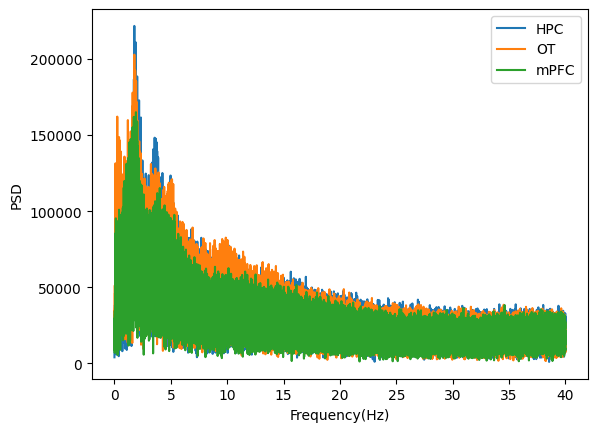

In [ ]:
####################################################################
PSD,freq=calc_PSD(channel_data['HPC'],2000,40)
plt.plot(freq,PSD)
PSD,freq=calc_PSD(channel_data['OT'],2000,40)
plt.plot(freq,PSD)
PSD,freq=calc_PSD(channel_data['mPFC'],2000,40)
plt.plot(freq,PSD)
plt.legend(['HPC','OT','mPFC'])
plt.xlabel('Frequency(Hz)')
plt.ylabel('PSD')
plt.show()
####################################################################

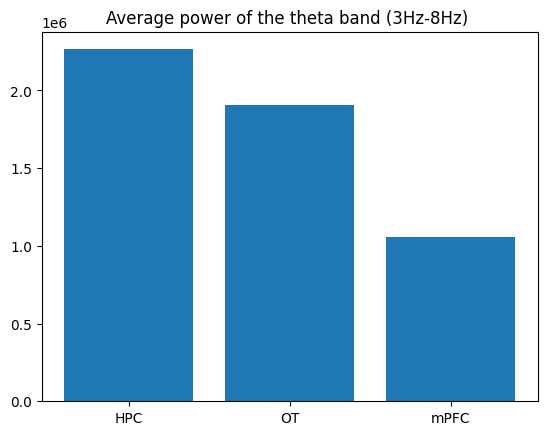

In [ ]:
##################################################
def Average_power(data,sample_rate,lower_freq,high_freq):
  fft_freq = np.fft.rfftfreq(len(data), 1/sample_rate)
  fre_ix=np.where((fft_freq<=high_freq) & (fft_freq>=lower_freq))[0]
  f_coef=np.zeros(fre_ix.shape,dtype=np.complex_)
  fft_val=np.fft.rfft(data)
  A=fft_val[fre_ix]
  Ave_p=np.mean(np.abs(A)**2)
  return Ave_p
A=['HPC','OT','mPFC']
B=[Average_power(channel_data['HPC'],2000,3,8),
   Average_power(channel_data['OT'],2000,3,8),
   Average_power(channel_data['mPFC'],2000,3,8)]
plt.bar(A,B)
plt.title('Average power of the theta band (3Hz-8Hz) ')
plt.show()
##################################################


# Preprocessing


In [ ]:
from scipy.signal import butter, filtfilt
def BPF_filter(data,frq_low,frq_high,filt_order):
    ##############################
    low=frq_low/(2000/2)
    high=frq_high/(2000/2)
    b, a = butter(filt_order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, data)
    ##############################
    return filtered_signal
channel_data['HPC']=BPF_filter(channel_data['HPC'],0.5,128,4)   #filter order=4
channel_data['OT']=BPF_filter(channel_data['OT'],0.5,128,4)
channel_data['mPFC']=BPF_filter(channel_data['mPFC'],0.5,128,4)

In [ ]:
def z_score(signal_matrix):  #It's worth noting that the input of this function is the signal converted into trials
    #############################
    for i in range(len(signal_matrix)):
      mean=np.mean(signal_matrix[i,:])
      std_dv = np.var(signal_matrix[i,:])**0.5
      #subtracting the mean of each trial and then dividing it by the standard deviation
      signal_matrix[i,:]=(signal_matrix[i,:]-mean*np.ones_like(signal_matrix[i,:]))/std_dv*np.ones_like(signal_matrix[i,:])
    #############################
    return signal_matrix

def epoch_data(data,digitalbyte, time_interval):
    ##############################
    t0,t1=time_interval[0],time_interval[1]
    data_epoched={}
    #Banana
    indices1=np.where((digitalbyte[1:] == 20) & (digitalbyte[:-1] == 0))[0]
    matrix_B=np.zeros((len(indices1),int(2000*t1-2000*t0)))
    for i in range(len(indices1)):
      matrix_B[i,:]=data[int(indices1[i]+2000*t0):int(indices1[i]+2000*t1)]
    #Lime
    indices2=np.where((digitalbyte[1:] == 40) & (digitalbyte[:-1] == 0))[0]
    matrix_L=np.zeros((len(indices2),int(2000*t1-2000*t0)))
    for i in range(len(indices2)):
      matrix_L[i,:]=data[int(indices2[i]+2000*t0):int(indices2[i]+2000*t1)]
    ##############################
    data_epoched['data_Banana']=z_score(matrix_B)
    data_epoched['data_Lime']=z_score(matrix_L)
    return data_epoched  #the output is in the rectangular matrix. The (i)th row represents the signals in trial (i).

time_interval=[-1.5,3] #stimulus_Time=0
channel_data['HPC_Preprocess']=epoch_data(channel_data['HPC'],channel_data['digitalbyte'], time_interval)
channel_data['OT_Preprocess']=epoch_data(channel_data['OT'],channel_data['digitalbyte'], time_interval)
channel_data['mPFC_Preprocess']=epoch_data(channel_data['mPFC'],channel_data['digitalbyte'], time_interval)

# Event-Related Potential (ERP)


In [ ]:
def calc_ERP(data):
    ##############################
    ERP=np.mean(data, axis=0).reshape(1, -1)
    ##############################
    return np.squeeze(ERP)

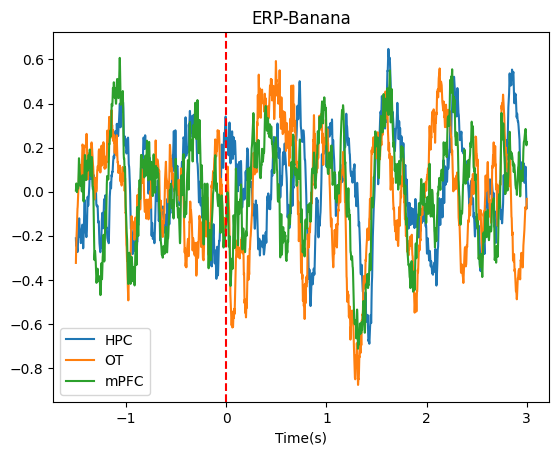

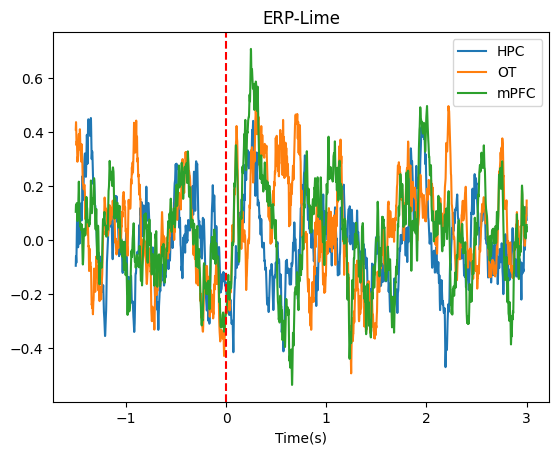

In [ ]:

####################################################################
time_interval=[-1.5,3]
delta_t=np.linspace(time_interval[0], time_interval[1], num=int((time_interval[1]-time_interval[0])*2000))
delta_t0=int(-time_interval[0]*2000)
                                                          #the baseline rejection
s1=calc_ERP(channel_data['HPC_Preprocess']['data_Banana'])-np.mean(calc_ERP(channel_data['HPC_Preprocess']['data_Banana'][:,0:delta_t0]))
s2=calc_ERP(channel_data['OT_Preprocess']['data_Banana'])-np.mean(calc_ERP(channel_data['OT_Preprocess']['data_Banana'][:,0:delta_t0]))
s3=calc_ERP(channel_data['mPFC_Preprocess']['data_Banana'])-np.mean(calc_ERP(channel_data['mPFC_Preprocess']['data_Banana'][:,0:delta_t0]))
plt.plot(delta_t,s1,delta_t,s2,delta_t,s3)
plt.axvline(x=0, color='red', linestyle='--'),plt.legend(['HPC','OT','mPFC']),plt.title('ERP-Banana'),plt.xlabel('Time(s)'),plt.show()

s1=calc_ERP(channel_data['HPC_Preprocess']['data_Lime'])-np.mean(calc_ERP(channel_data['HPC_Preprocess']['data_Lime'][:,0:delta_t0]))
s2=calc_ERP(channel_data['OT_Preprocess']['data_Lime'])-np.mean(calc_ERP(channel_data['OT_Preprocess']['data_Lime'][:,0:delta_t0]))
s3=calc_ERP(channel_data['mPFC_Preprocess']['data_Lime'])-np.mean(calc_ERP(channel_data['mPFC_Preprocess']['data_Lime'][:,0:delta_t0]))
plt.plot(delta_t,s1,delta_t,s2,delta_t,s3)
plt.axvline(x=0, color='red', linestyle='--'),plt.legend(['HPC','OT','mPFC']),plt.title('ERP-Lime'),plt.xlabel('Time(s)')
plt.show()
####################################################################


# Phase-Lock Value (PLV)

In [ ]:
from scipy.signal import hilbert
def bandpass_filter(signal, low_freq, high_freq):
    #############################
    fft_freq=np.fft.rfftfreq(len(signal),1/2000)
    fre_ix=np.where((fft_freq>=low_freq) & (fft_freq<=high_freq))
    f_coef=np.zeros(fft_freq.shape,dtype=np.complex_)
    fft_val=np.fft.rfft(signal)
    f_coef[fre_ix]=fft_val[fre_ix]
    signal_f=np.fft.irfft(f_coef)
    #############################
    return signal_f

def calc_PLV(data1,data2, frq_range): #time_range and filt_order was omited:) because I used fast fourier transformation(FFT)!
    ##############################
    global n
    delta_f=int((frq_range[1]-frq_range[0])/n)
    PLV=np.zeros((len(data1),n))
    for j in range(len(data1)):
      signal1=data1[j,:]
      signal2=data2[j,:]
      for i in range(n):
          signal1_F=bandpass_filter(signal1,frq_range[0]+i*delta_f,frq_range[0]+(i+1)*delta_f)
          signal2_F=bandpass_filter(signal2,frq_range[0]+i*delta_f,frq_range[0]+(i+1)*delta_f)
          hilbert_transform1 = hilbert(signal1_F)
          Z1=1j*hilbert_transform1.imag+signal1_F
          hilbert_transform2 = hilbert(signal2_F)
          Z2=1j*hilbert_transform2.imag+signal2_F
          delta_phi=np.angle((Z1*np.conj(Z2))/(np.abs(Z1)*np.abs(Z2)))
          PLV[j,i]=np.abs(np.mean(np.exp(delta_phi*1j)))
    PLV_mean=np.mean(PLV, axis=0).reshape(1, -1)
    ##############################
    return np.squeeze(PLV_mean)

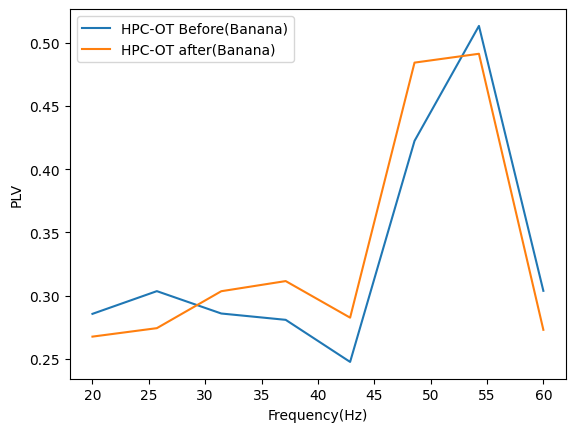

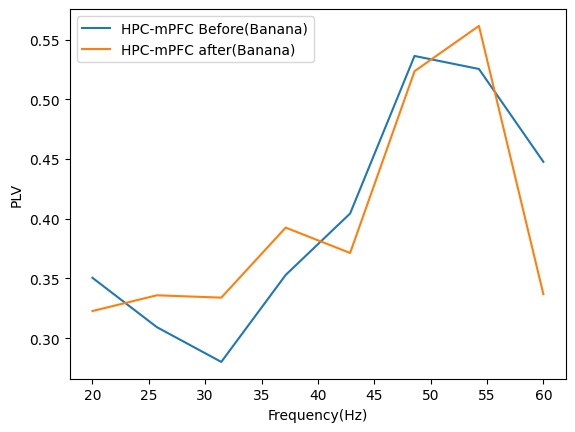

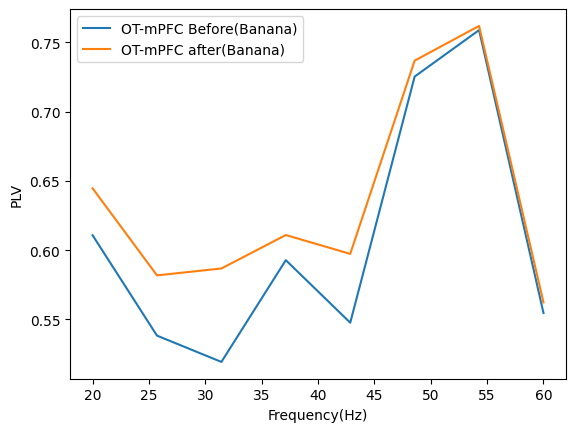

In [ ]:
####################################################################
n=8   #n divide the given frequency range into small frequency bin in order to be filtered(narrow-band filter). for n=8 we get the best result!
time_interval1=[-1.5,0]
time_interval2=[0,1.5]
delta_f=np.linspace(20,60,num=n)

##### The HPC-OT Phase-Lock Value (for Banana)
signal1=epoch_data(channel_data['HPC'],channel_data['digitalbyte'], time_interval1)['data_Banana']
signal2=epoch_data(channel_data['OT'],channel_data['digitalbyte'], time_interval1)['data_Banana']
A=calc_PLV(signal1,signal2,[20,60])
signal1=epoch_data(channel_data['HPC'],channel_data['digitalbyte'], time_interval2)['data_Banana']
signal2=epoch_data(channel_data['OT'],channel_data['digitalbyte'], time_interval2)['data_Banana']
B=calc_PLV(signal1,signal2,[20,60])
plt.plot(delta_f,A,delta_f,B)
plt.xlabel('Frequency(Hz)'),plt.ylabel('PLV'),plt.legend(['HPC-OT Before(Banana)','HPC-OT after(Banana)']),plt.show()

##### The HPC-mPFC Phase-Lock Value (for Banana)
signal1=epoch_data(channel_data['HPC'],channel_data['digitalbyte'], time_interval1)['data_Banana']
signal2=epoch_data(channel_data['mPFC'],channel_data['digitalbyte'], time_interval1)['data_Banana']
A=calc_PLV(signal1,signal2,[20,60])
time_interval=[0,1.5]
signal1=epoch_data(channel_data['HPC'],channel_data['digitalbyte'], time_interval2)['data_Banana']
signal2=epoch_data(channel_data['mPFC'],channel_data['digitalbyte'], time_interval2)['data_Banana']
B=calc_PLV(signal1,signal2,[20,60])
plt.plot(delta_f,A,delta_f,B)
plt.xlabel('Frequency(Hz)'),plt.ylabel('PLV'),plt.legend(['HPC-mPFC Before(Banana)','HPC-mPFC after(Banana)']),plt.show()

##### The OT-mPFC Phase-Lock Value (for Banana)
signal1=epoch_data(channel_data['OT'],channel_data['digitalbyte'], time_interval1)['data_Banana']
signal2=epoch_data(channel_data['mPFC'],channel_data['digitalbyte'], time_interval1)['data_Banana']
A=calc_PLV(signal1,signal2,[20,60])
time_interval=[0,1.5]
signal1=epoch_data(channel_data['OT'],channel_data['digitalbyte'], time_interval2)['data_Banana']
signal2=epoch_data(channel_data['mPFC'],channel_data['digitalbyte'], time_interval2)['data_Banana']
B=calc_PLV(signal1,signal2,[20,60])
plt.plot(delta_f,A,delta_f,B)
plt.xlabel('Frequency(Hz)'),plt.ylabel('PLV'),plt.legend(['OT-mPFC Before(Banana)','OT-mPFC after(Banana)'])
plt.show()


####################################################################

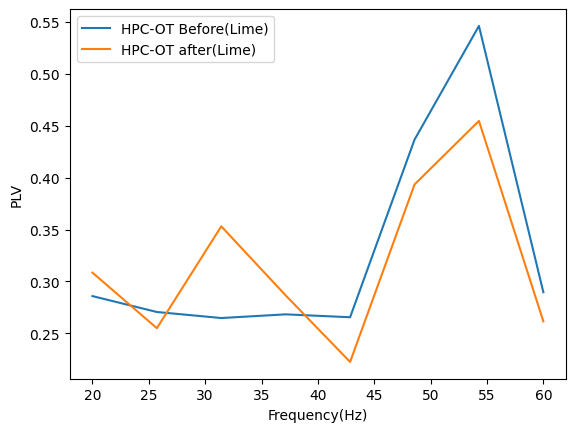

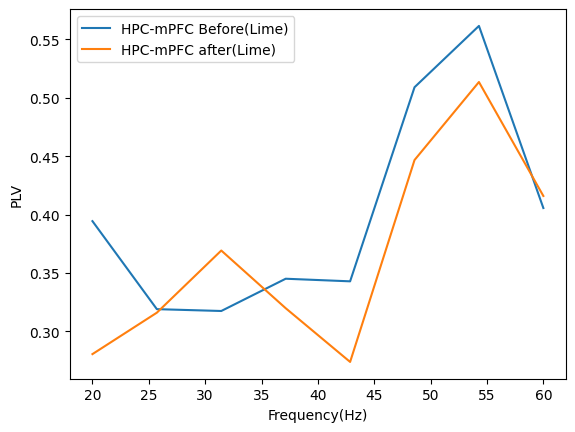

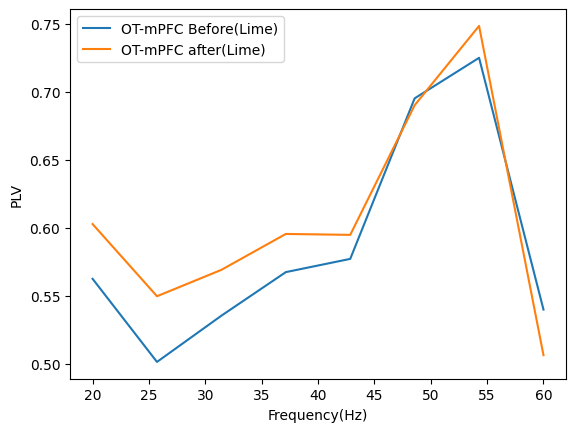

In [ ]:
##### The HPC-OT Phase-Lock Value (for Lime)
signal1=epoch_data(channel_data['HPC'],channel_data['digitalbyte'], time_interval1)['data_Lime']
signal2=epoch_data(channel_data['OT'],channel_data['digitalbyte'], time_interval1)['data_Lime']
A=calc_PLV(signal1,signal2,[20,60])
signal1=epoch_data(channel_data['HPC'],channel_data['digitalbyte'], time_interval2)['data_Lime']
signal2=epoch_data(channel_data['OT'],channel_data['digitalbyte'], time_interval2)['data_Lime']
B=calc_PLV(signal1,signal2,[20,60])
plt.plot(delta_f,A,delta_f,B)
plt.xlabel('Frequency(Hz)'),plt.ylabel('PLV'),plt.legend(['HPC-OT Before(Lime)','HPC-OT after(Lime)']),plt.show()

##### The HPC-mPFC Phase-Lock Value (for Lime)
signal1=epoch_data(channel_data['HPC'],channel_data['digitalbyte'], time_interval1)['data_Lime']
signal2=epoch_data(channel_data['mPFC'],channel_data['digitalbyte'], time_interval1)['data_Lime']
A=calc_PLV(signal1,signal2,[20,60])
time_interval=[0,1.5]
signal1=epoch_data(channel_data['HPC'],channel_data['digitalbyte'], time_interval2)['data_Lime']
signal2=epoch_data(channel_data['mPFC'],channel_data['digitalbyte'], time_interval2)['data_Lime']
B=calc_PLV(signal1,signal2,[20,60])
plt.plot(delta_f,A,delta_f,B)
plt.xlabel('Frequency(Hz)'),plt.ylabel('PLV'),plt.legend(['HPC-mPFC Before(Lime)','HPC-mPFC after(Lime)']),plt.show()

##### The OT-mPFC Phase-Lock Value (for Lime)
signal1=epoch_data(channel_data['OT'],channel_data['digitalbyte'], time_interval1)['data_Lime']
signal2=epoch_data(channel_data['mPFC'],channel_data['digitalbyte'], time_interval1)['data_Lime']
A=calc_PLV(signal1,signal2,[20,60])
time_interval=[0,1.5]
signal1=epoch_data(channel_data['OT'],channel_data['digitalbyte'], time_interval2)['data_Lime']
signal2=epoch_data(channel_data['mPFC'],channel_data['digitalbyte'], time_interval2)['data_Lime']
B=calc_PLV(signal1,signal2,[20,60])
plt.plot(delta_f,A,delta_f,B)
plt.xlabel('Frequency(Hz)'),plt.ylabel('PLV'),plt.legend(['OT-mPFC Before(Lime)','OT-mPFC after(Lime)'])
plt.show()

# Phase-Amplitude Coupling (PAC)

Now, we aim to analyze the data and compute the Phase-Amplitude Coupling (PAC) for each channel. First thing first, as explained in [the paper](https://doi.org/10.1038/s41598-019-48870-2) , we need to find the Bilinear time–frequency distribution of the signal using the RID-Rihaczek method.

In [ ]:
def _rhu(n):
    '''
    Return integer rounded of the input. The half will round up.
    1.3 -> 1
    2.5 -> 3
    -0.5 -> 0
    -0.3 -> -1
    '''
    return int(math.floor(n + 0.5))


def _datawrap(x: np.ndarray, n: int) -> np.ndarray:
    '''
    The calculation of signal spectrum, such as periodogram, uses FFT internally,
    where the length of FFT is denoted as NFFT. In theory, when using FFT,
    the signal in both time domain and frequency domain are discrete and periodic,
    where the period is given by NFFT. Hence, if you specify an NFFT that is less
    than the signal length, it actually introduces the aliasing in the time domain
    and make the signal (even if its length is N>NFFT) periodic with NFFT.
    When you take FFT of this sequence, you are working with this aliased sequence.
    This is what datawrap do for you.

    For example: Sequence 1 2 3 4 5, period 5, it returns
        1 2 3 4 5
                  1 2 3 4 5
                            1 2 3 4 5
        --------------------------------
              ... 1 2 3 4 5 ...

    i.e., original series. assume a period of 3, then it looks like

        1 2 3 4 5
              1 2 3 4 5
                    1 2 3 4 5
        ------------------------
          ... 5 7 3 ...

    A sequence that is wrapped around and has only a length of 3.

    >>> _datawrap(range(1, 6),3)
    array([5, 7, 3])

    '''
    return np.array([sum(x[i::n]) for i in range(n)])


def _chwi_krn(D: np.ndarray, L: np.ndarray, A: int = None):
    '''

    CHWI_KRN Choi-Williams kernel function.

    https://en.wikipedia.org/wiki/Bilinear_time%E2%80%93frequency_distribution#Choi%E2%80%93Williams_distribution_function

    K = _chwi_krn(D, L, A) returns the values K of the Choi-Williams kernel function
    evaluated at the doppler-values in matrix D and the lag-values in matrix L.
    Matrices D and L must have the same size. The values in D should be in the range
    between -1 and +1 (with +1 being the Nyquist frequency). The parameter A is
    optional and controls the "diagonal bandwidth" of the kernel. Matrix K is of the
    same size as the matrices D and L. Parameter A defaults to 10 if omitted.

    Copyright (c) 1998 by Robert M. Nickel
    Revision: 1.1.1.1
    Date: 2001/03/05 09:09:36

    Written by: Mahdi Kiani, March 2021

    '''

    if A is None:
        A = 10
    K = np.exp((-1/(A*A)) * (D*D*L*L))

    return K

def rid_rihaczek(x: np.ndarray, fbins: int):
    '''
    Munia, T.T.K., Aviyente, S. Time-Frequency Based Phase-Amplitude
    Coupling Measure For Neuronal Oscillations. Sci Rep 9, 12441 (2019).
    https://doi.org/10.1038/s41598-019-48870-2

    This function computes reduced interference Rihaczek distribution

    Parameter:
        x: signal
        fbins=required frequency bins

    Returns:
        tfd = Generated reduced interference Rihaczek distribution

    Written by: Mahdi Kiani, March 2021
    '''

    tbins = x.shape[0]
    amb = np.zeros((tbins, tbins))
    for tau in range(tbins):
        amb[tau, :] = (np.conj(x) * np.concatenate((x[tau:], x[:tau])))

    ambTemp = np.concatenate(
        (amb[:, _rhu(tbins/2):], amb[:, :_rhu(tbins/2)]), axis=1)
    amb1 = np.concatenate(
        (ambTemp[_rhu(tbins/2):, :], ambTemp[:_rhu(tbins/2), :]), axis=0)

    D = np.outer(np.linspace(-1, 1, tbins), np.linspace(-1, 1, tbins), )
    K = _chwi_krn(D, D, 0.01)
    df = K[:amb1.shape[0], :amb1.shape[1]]
    ambf = amb1 * df

    A = np.zeros((fbins, tbins))
    tbins = tbins - 1

    if tbins != fbins:
        for tt in range(tbins):
            A[:, tt] = _datawrap(ambf[:, tt], fbins)
    else:
        A = ambf

    tfd = np.fft.fft(A, axis=0)

    return tfd

In [ ]:
def calc_MVL(tfd,tfd2, fph, famp):
    ##############################
    A_fa=np.abs(tfd)
    phi_fp=np.exp(np.angle(tfd2)*1j)
    m=np.abs(np.mean(A_fa[famp,:]*phi_fp[fph,:]))
    ##############################
    return m

def calc_PAC(data1,data2, fph_range, famp_range, fbins): # the parameter 'fbins' is added!
    ##############################
    tfd=rid_rihaczek(data1,fbins)
    tfd2=tfd
    fp1,fp2=int((fph_range[0]+1)*fbins/2000),int((fph_range[1]+1)*fbins/2000)    #the indices of given F_ph and F_amp
    fa1,fa2=int((famp_range[0]+1)*fbins/2000),int((famp_range[1]+1)*fbins/2000)
    delta_fph=fp2-fp1
    MVL=np.zeros((fp2-fp1,fa2-fa1))
    for i in range(fp2-fp1):
      for j in range(fa2-fa1):
        MVL[i,j]=calc_MVL(tfd,tfd2, i+fp1, j+fa1)
    ##############################
    return MVL
def calc_Ir_PAC(data1,data2, fph_range, famp_range, fbins):
    ##############################
    tfd=rid_rihaczek(data1,fbins)
    tfd2=rid_rihaczek(data2,fbins)
    fp1,fp2=int((fph_range[0]+1)*fbins/2000),int((fph_range[1]+1)*fbins/2000)
    fa1,fa2=int((famp_range[0]+1)*fbins/2000),int((famp_range[1]+1)*fbins/2000)
    delta_fph=fp2-fp1
    MVL=np.zeros((fp2-fp1,fa2-fa1))
    for i in range(fp2-fp1):
      for j in range(fa2-fa1):
        MVL[i,j]=calc_MVL(tfd,tfd2, i+fp1, j+fa1)
    ##############################
    return MVL

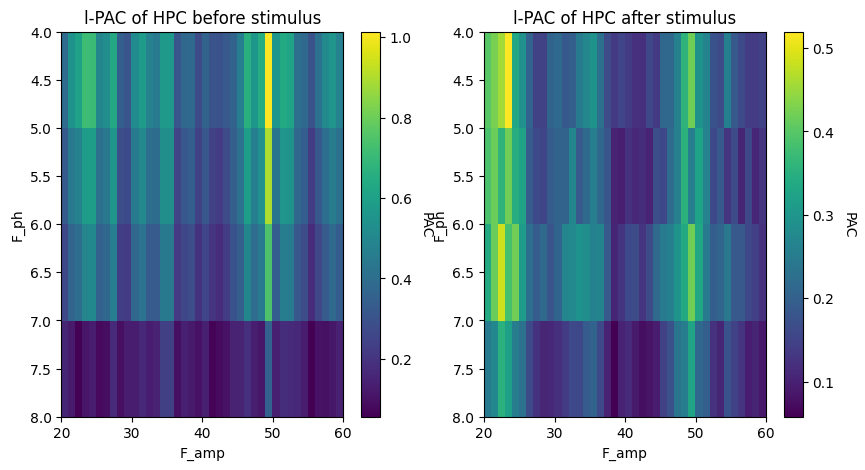

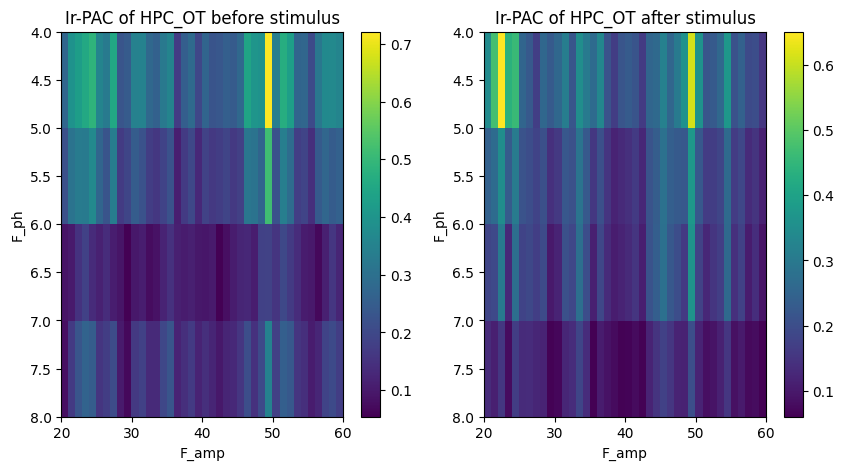

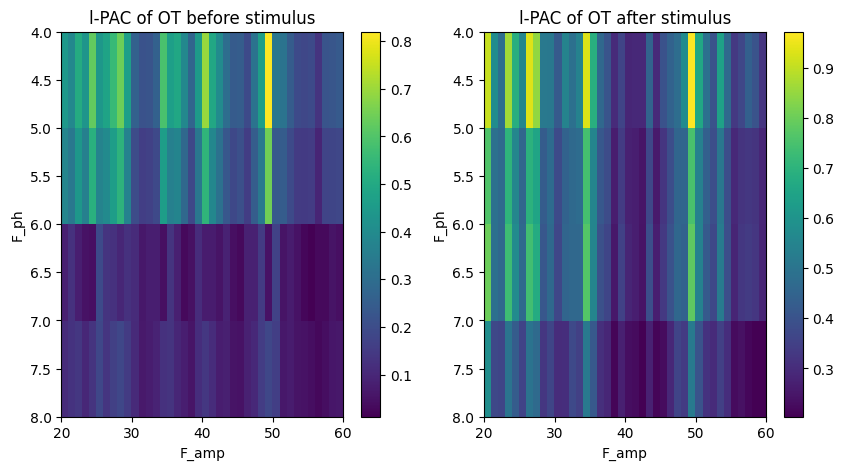

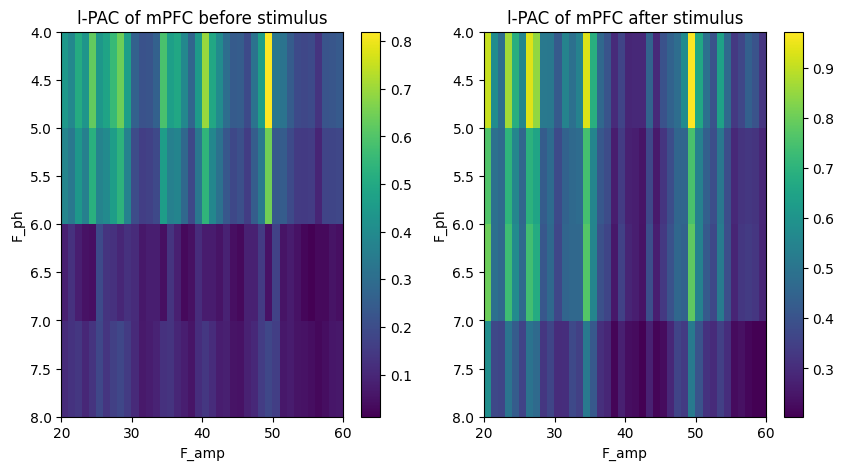

In [ ]:
####################################################################
time_range1,time_range2=[-1,0],[0,1]
fbins=2000
signal1_HPC=calc_ERP(epoch_data(channel_data['HPC'],channel_data['digitalbyte'],time_range1)['data_Banana'])
signal2_HPC=calc_ERP(epoch_data(channel_data['HPC'],channel_data['digitalbyte'],time_range2)['data_Banana'])
signal1_OT=calc_ERP(epoch_data(channel_data['OT'],channel_data['digitalbyte'],time_range1)['data_Banana'])
signal2_OT=calc_ERP(epoch_data(channel_data['OT'],channel_data['digitalbyte'],time_range2)['data_Banana'])
signal1_mPFC=calc_ERP(epoch_data(channel_data['mPFC'],channel_data['digitalbyte'],time_range1)['data_Banana'])
signal2_mPFC=calc_ERP(epoch_data(channel_data['mPFC'],channel_data['digitalbyte'],time_range2)['data_Banana'])

fig,axs=plt.subplots(1,2,figsize=(10,5))   #l-PAC of HPC
fph_range,famp_range=[4,8],[20,60]
im1=axs[0].imshow(calc_PAC(signal1_HPC,signal1_HPC,fph_range,famp_range,fbins),extent=[20, 60 , 8 , 4])
axs[0].set_title('l-PAC of HPC before stimulus(Banana)'),axs[0].set_xlabel('F_amp'),axs[0].set_ylabel('F_ph'),axs[0].set_aspect('auto')
im2=axs[1].imshow(calc_PAC(signal2_HPC,signal2_HPC,fph_range,famp_range,fbins),extent=[20, 60 , 8 , 4])
axs[1].set_title('l-PAC of HPC after stimulus(Banana)'),axs[1].set_xlabel('F_amp'),axs[1].set_ylabel('F_ph'),axs[1].set_aspect('auto')
cbar1=fig.colorbar(im1, ax=axs[0])
cbar1.set_label('PAC', rotation=270, labelpad=15)
cbar2 = fig.colorbar(im2, ax=axs[1])
cbar2.set_label('PAC', rotation=270, labelpad=15)

fig,axs=plt.subplots(1,2,figsize=(10,5))  #Ir-PAC of HPC_OT
fph_range,famp_range=[4,8],[20,60]
im1=axs[0].imshow(calc_Ir_PAC(signal1_HPC,signal1_OT,fph_range,famp_range,fbins),extent=[20, 60 , 8 , 4])
axs[0].set_title('Ir-PAC of HPC_OT before stimulus(Banana)'),axs[0].set_xlabel('F_amp'),axs[0].set_ylabel('F_ph'),axs[0].set_aspect('auto')
im2=axs[1].imshow(calc_Ir_PAC(signal2_HPC,signal2_OT,fph_range,famp_range,fbins),extent=[20, 60 , 8 , 4])
axs[1].set_title('Ir-PAC of HPC_OT after stimulus(Banana)'),axs[1].set_xlabel('F_amp'),axs[1].set_ylabel('F_ph'),axs[1].set_aspect('auto')
cbar1=fig.colorbar(im1, ax=axs[0])
cbar2 = fig.colorbar(im2, ax=axs[1])

fig,axs=plt.subplots(1,2,figsize=(10,5)) #l-PAC of OT
fph_range,famp_range=[4,8],[20,60]
im1=axs[0].imshow(calc_PAC(signal1_OT,signal1_OT,fph_range,famp_range,fbins),extent=[20, 60 , 8 , 4])
axs[0].set_title('l-PAC of OT before stimulus(Banana)'),axs[0].set_xlabel('F_amp'),axs[0].set_ylabel('F_ph'),axs[0].set_aspect('auto')
im2=axs[1].imshow(calc_PAC(signal2_OT,signal2_OT,fph_range,famp_range,fbins),extent=[20, 60 , 8 , 4])
axs[1].set_title('l-PAC of OT after stimulus(Banana)'),axs[1].set_xlabel('F_amp'),axs[1].set_ylabel('F_ph'),axs[1].set_aspect('auto')
cbar1=fig.colorbar(im1, ax=axs[0])
cbar2 = fig.colorbar(im2, ax=axs[1])

fig,axs=plt.subplots(1,2,figsize=(10,5))   #l-PAC of mPFC
fph_range,famp_range=[4,8],[20,60]
im1=axs[0].imshow(calc_PAC(signal1_OT,signal1_OT,fph_range,famp_range,fbins),extent=[20, 60 , 8 , 4])
axs[0].set_title('l-PAC of mPFC before stimulus(Banana)'),axs[0].set_xlabel('F_amp'),axs[0].set_ylabel('F_ph'),axs[0].set_aspect('auto')
im2=axs[1].imshow(calc_PAC(signal2_OT,signal2_OT,fph_range,famp_range,fbins),extent=[20, 60 , 8 , 4])
axs[1].set_title('l-PAC of mPFC after stimulus(Banana)'),axs[1].set_xlabel('F_amp'),axs[1].set_ylabel('F_ph'),axs[1].set_aspect('auto')
cbar1=fig.colorbar(im1, ax=axs[0])
cbar2 = fig.colorbar(im2, ax=axs[1])

####################################################################

In [ ]:
############################################
signal1_HPC=calc_ERP(epoch_data(channel_data['HPC'],channel_data['digitalbyte'],time_range1)['data_Lime'])
signal2_HPC=calc_ERP(epoch_data(channel_data['HPC'],channel_data['digitalbyte'],time_range2)['data_Lime'])
signal1_OT=calc_ERP(epoch_data(channel_data['OT'],channel_data['digitalbyte'],time_range1)['data_Lime'])
signal2_OT=calc_ERP(epoch_data(channel_data['OT'],channel_data['digitalbyte'],time_range2)['data_Lime'])
signal1_mPFC=calc_ERP(epoch_data(channel_data['mPFC'],channel_data['digitalbyte'],time_range1)['data_Lime'])
signal2_mPFC=calc_ERP(epoch_data(channel_data['mPFC'],channel_data['digitalbyte'],time_range2)['data_Lime'])

fig,axs=plt.subplots(1,2,figsize=(10,5))   #l-PAC of HPC
fph_range,famp_range=[4,8],[20,60]
im1=axs[0].imshow(calc_PAC(signal1_HPC,signal1_HPC,fph_range,famp_range,fbins),extent=[20, 60 , 8 , 4])
axs[0].set_title('l-PAC of HPC before stimulus(Lime)'),axs[0].set_xlabel('F_amp'),axs[0].set_ylabel('F_ph'),axs[0].set_aspect('auto')
im2=axs[1].imshow(calc_PAC(signal2_HPC,signal2_HPC,fph_range,famp_range,fbins),extent=[20, 60 , 8 , 4])
axs[1].set_title('l-PAC of HPC after stimulus(Lime)'),axs[1].set_xlabel('F_amp'),axs[1].set_ylabel('F_ph'),axs[1].set_aspect('auto')
cbar1=fig.colorbar(im1, ax=axs[0])
cbar1.set_label('PAC', rotation=270, labelpad=15)
cbar2 = fig.colorbar(im2, ax=axs[1])
cbar2.set_label('PAC', rotation=270, labelpad=15)

fig,axs=plt.subplots(1,2,figsize=(10,5))  #Ir-PAC of HPC_OT
fph_range,famp_range=[4,8],[20,60]
im1=axs[0].imshow(calc_Ir_PAC(signal1_HPC,signal1_OT,fph_range,famp_range,fbins),extent=[20, 60 , 8 , 4])
axs[0].set_title('Ir-PAC of HPC_OT before stimulus(Lime)'),axs[0].set_xlabel('F_amp'),axs[0].set_ylabel('F_ph'),axs[0].set_aspect('auto')
im2=axs[1].imshow(calc_Ir_PAC(signal2_HPC,signal2_OT,fph_range,famp_range,fbins),extent=[20, 60 , 8 , 4])
axs[1].set_title('Ir-PAC of HPC_OT after stimulus(Lime)'),axs[1].set_xlabel('F_amp'),axs[1].set_ylabel('F_ph'),axs[1].set_aspect('auto')
cbar1=fig.colorbar(im1, ax=axs[0])
cbar2 = fig.colorbar(im2, ax=axs[1])

fig,axs=plt.subplots(1,2,figsize=(10,5)) #l-PAC of OT
fph_range,famp_range=[4,8],[20,60]
im1=axs[0].imshow(calc_PAC(signal1_OT,signal1_OT,fph_range,famp_range,fbins),extent=[20, 60 , 8 , 4])
axs[0].set_title('l-PAC of OT before stimulus(Lime)'),axs[0].set_xlabel('F_amp'),axs[0].set_ylabel('F_ph'),axs[0].set_aspect('auto')
im2=axs[1].imshow(calc_PAC(signal2_OT,signal2_OT,fph_range,famp_range,fbins),extent=[20, 60 , 8 , 4])
axs[1].set_title('l-PAC of OT after stimulus(Lime)'),axs[1].set_xlabel('F_amp'),axs[1].set_ylabel('F_ph'),axs[1].set_aspect('auto')
cbar1=fig.colorbar(im1, ax=axs[0])
cbar2 = fig.colorbar(im2, ax=axs[1])

fig,axs=plt.subplots(1,2,figsize=(10,5))   #l-PAC of mPFC
fph_range,famp_range=[4,8],[20,60]
im1=axs[0].imshow(calc_PAC(signal1_OT,signal1_OT,fph_range,famp_range,fbins),extent=[20, 60 , 8 , 4])
axs[0].set_title('l-PAC of mPFC before stimulus(Lime)'),axs[0].set_xlabel('F_amp'),axs[0].set_ylabel('F_ph'),axs[0].set_aspect('auto')
im2=axs[1].imshow(calc_PAC(signal2_OT,signal2_OT,fph_range,famp_range,fbins),extent=[20, 60 , 8 , 4])
axs[1].set_title('l-PAC of mPFC after stimulus(Lime)'),axs[1].set_xlabel('F_amp'),axs[1].set_ylabel('F_ph'),axs[1].set_aspect('auto')
cbar1=fig.colorbar(im1, ax=axs[0])
cbar2 = fig.colorbar(im2, ax=axs[1])
#############################################

# Time-Varying Phase-Amplitude Coupling (tv-PAC)

In [ ]:
def calc_tvPAC(data, fph_range, famp_range, t_win, overlap,fbins): #overlap is less than 1!
    ##############################
    L=np.shape(data)[0]
    dL=int((t_win)*2000)
    L0=(1-overlap)*dL
    Lprime=L- overlap*dL
    n=int(Lprime/L0)
    fa1,fa2=int((famp_range[0]+1)*fbins/2000),int((famp_range[1]+1)*fbins/2000)
    tvPAC=np.zeros((n,fa2-fa1))
    for i in range(n):
      t0=int(i*L0)
      M=calc_PAC(data[t0:t0+dL],data[t0:t0+dL],fph_range,famp_range,fbins)
      tvPAC[i,:]=np.mean(M, axis=0).reshape(1, -1)
    ##############################
    return tvPAC

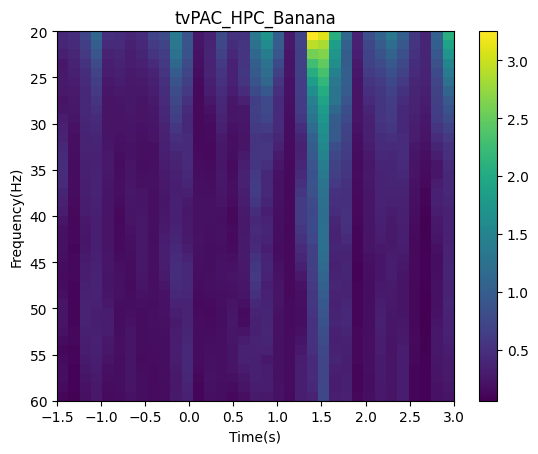

"\nsignal_ERP_OT=calc_ERP(channel_data['OT_Preprocess']['data_Banana'])\ntvPAC_OT=calc_tvPAC(signal_ERP_OT,[4,8],[20,60],0.25,0.75,2000)\nplt.imshow(tvPAC_OT.T,extent=[-1.5, 3 , 60 , 20])\nplt.colorbar(),plt.gca().set_aspect('auto'),plt.title('tvPAC_OT_Banana'),plt.xlabel('Time(s)'),plt.ylabel('Frequency(Hz)'),plt.show()\n\nsignal_ERP_mPFC=calc_ERP(channel_data['mPFC_Preprocess']['data_Banana'])\ntvPAC_mPFC=calc_tvPAC(signal_ERP_mPFC,[4,8],[20,60],0.25,0.75,2000)\nplt.imshow(tvPAC_mPFC.T,extent=[-1.5, 3 , 60 , 20])\nplt.colorbar(),plt.gca().set_aspect('auto'),plt.title('tvPAC_mPFC_Banana'),plt.xlabel('Time(s)'),plt.ylabel('Frequency(Hz)')\nplt.show()\n"

In [ ]:
signal_ERP_HPC=calc_ERP(channel_data['HPC_Preprocess']['data_Banana'])
tvPAC_HPC=calc_tvPAC(signal_ERP_HPC,[4,8],[20,60],0.25,0.75,2000)
plt.imshow(tvPAC_HPC.T,extent=[-1.5, 3 , 60 , 20])
plt.colorbar(),plt.gca().set_aspect('auto'),plt.title('tvPAC_HPC_Banana'),plt.xlabel('Time(s)'),plt.ylabel('Frequency(Hz)'),plt.show()

signal_ERP_OT=calc_ERP(channel_data['OT_Preprocess']['data_Banana'])
tvPAC_OT=calc_tvPAC(signal_ERP_OT,[4,8],[20,60],0.25,0.75,2000)
plt.imshow(tvPAC_OT.T,extent=[-1.5, 3 , 60 , 20])
plt.colorbar(),plt.gca().set_aspect('auto'),plt.title('tvPAC_OT_Banana'),plt.xlabel('Time(s)'),plt.ylabel('Frequency(Hz)'),plt.show()

signal_ERP_mPFC=calc_ERP(channel_data['mPFC_Preprocess']['data_Banana'])
tvPAC_mPFC=calc_tvPAC(signal_ERP_mPFC,[4,8],[20,60],0.25,0.75,2000)
plt.imshow(tvPAC_mPFC.T,extent=[-1.5, 3 , 60 , 20])
plt.colorbar(),plt.gca().set_aspect('auto'),plt.title('tvPAC_mPFC_Banana'),plt.xlabel('Time(s)'),plt.ylabel('Frequency(Hz)')
plt.show()


In [ ]:
signal_ERP_HPC=calc_ERP(channel_data['HPC_Preprocess']['data_Lime'])
tvPAC_HPC=calc_tvPAC(signal_ERP_HPC,[4,8],[20,60],0.25,0.75,2000)
plt.imshow(tvPAC_HPC.T,extent=[-1.5, 3 , 60 , 20])
plt.colorbar(),plt.gca().set_aspect('auto'),plt.title('tvPAC_HPC_Lime'),plt.xlabel('Time(s)'),plt.ylabel('Frequency(Hz)'),plt.show()

signal_ERP_OT=calc_ERP(channel_data['OT_Preprocess']['data_Lime'])
tvPAC_OT=calc_tvPAC(signal_ERP_OT,[4,8],[20,60],0.25,0.75,2000)
plt.imshow(tvPAC_OT.T,extent=[-1.5, 3 , 60 , 20])
plt.colorbar(),plt.gca().set_aspect('auto'),plt.title('tvPAC_OT_Lime'),plt.xlabel('Time(s)'),plt.ylabel('Frequency(Hz)'),plt.show()

signal_ERP_mPFC=calc_ERP(channel_data['mPFC_Preprocess']['data_Lime'])
tvPAC_mPFC=calc_tvPAC(signal_ERP_mPFC,[4,8],[20,60],0.25,0.75,2000)
plt.imshow(tvPAC_mPFC.T,extent=[-1.5, 3 , 60 , 20])
plt.colorbar(),plt.gca().set_aspect('auto'),plt.title('tvPAC_mPFC_Lime'),plt.xlabel('Time(s)'),plt.ylabel('Frequency(Hz)')
plt.show()